<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Загрузим данные и выведем первые строки таблицы.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
print(data.head(10))

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   
5          6    15574012       Chu          645     Spain    Male   44   
6          7    15592531  Bartlett          822    France    Male   50   
7          8    15656148    Obinna          376   Germany  Female   29   
8          9    15792365        He          501    France    Male   44   
9         10    15592389        H?          684    France    Male   27   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0       

In [3]:
# посмотрим информацию по таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
# в столбце с пропусками заполним пропуски медианой и проверим, что пропуски заполнены
data.loc[data['Tenure'].isna(), 'Tenure'] = data['Tenure'].median()
data['Tenure'].isna().sum()

0

In [5]:
# подготовим таблицу для исследования без столбцов, не несущих смысловой нагрузки, удалив их
data_new = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data_new.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Исследование задачи

Объявим переменные с целевым признаком и остальными признаками, разделим данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1, проверим размер полученных выборок.

In [6]:
# объявим переменные с целевым и остальными признаками
target = data_new['Exited']
features = data_new.drop(['Exited'], axis=1)
# сначала разделим на обучающую и остальную выборки в соотношении 60/40
features_train, features_rest, target_train, target_rest = train_test_split(features, target, test_size=0.4, random_state=12345)

In [7]:
# разделимполученную выборку rest пополам на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(features_rest, target_rest, test_size=0.5, random_state=12345)

In [8]:
# проверим размер полученных выборок
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000,)
(2000,)
(2000,)
(6000, 10)
(2000, 10)
(2000, 10)


In [9]:
# проверим и выведем признаки какого типа хранятся в таблице
print(data_new.dtypes)

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


In [10]:
# преобразуем категориальные признаки Gender и Geography из категориальных в численные
features_train = pd.get_dummies(features_train, drop_first=True)

In [11]:
# выведем первые строки таблицы
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,567,35,8.0,153137.74,1,1,0,88659.07,0,1,1
3411,711,37,8.0,113899.92,1,0,0,80215.20,0,0,0
6027,850,44,3.0,140393.65,2,0,1,186285.52,1,0,1
1247,512,24,6.0,0.00,2,1,0,37654.31,0,0,1
3716,665,27,2.0,147435.96,1,0,0,187508.06,1,0,0


In [12]:
features_valid = pd.get_dummies(features_valid, drop_first=True)

In [13]:
features_test = pd.get_dummies(features_test, drop_first=True)

In [14]:
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000,)
(2000,)
(2000,)
(6000, 11)
(2000, 11)
(2000, 11)


In [15]:
# приведем количественные признаки с разным масштабом CreditScore, Age, Tenure, Balance и EstimatedSalary к одному масштабу методом стандартизации
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,1,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,1,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,2,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,2,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,1,0,0,1.524268,1,0,0


In [16]:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Тип данных из категориальных изменен на количественный, а количественные данные с разным масштабом масштабированы.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


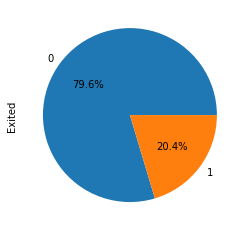

In [17]:
# проверим, как часто в целевом признаке встречается класс «1» или «0»
class_frequency = target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='pie', y = "Exited",
                                       label = "Exited",
                                       autopct='%1.1f%%')
plt.show()

Соотношение классов примерно 4 к 1, следовательно классы несбалансированы.

Обучим модели без учета дисбаланса и оценим метрику f1.

In [18]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.33108108108108103



Для моделей решающее дерево и случайный лес подберем гиперпараметры.

In [19]:
best_model = None
best_result = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result

print("max_depth = ", depth, "F1:", best_result)

max_depth =  10 F1: 0.5696969696969697


In [20]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 101, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("n_estimators = ", est,"max_depth = ", depth, "F1:", best_result)

n_estimators =  100 max_depth =  10 F1: 0.5891238670694864


Наилучший результат показала модель случайный лес с гиперпараметрами n_estimators 100 и max_depth 10. 

## Борьба с дисбалансом

Ранее мы выяснили, что соотношение классов примерно 4 к 1, следовательно классы несбалансированы.

Улучшим модели с учетом дисбаланса. Взвесим класссы, сначала применив технику upsampling, т.е. сделаем объекты редкого класса не такими редкими.

In [21]:
features_zeros = features_train[target_train == 0] 
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

In [22]:
print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4804, 11)
(1196, 11)
(4804,)
(1196,)


In [23]:
features_ones_upsampled = resample(features_ones,
             replace=True,
             n_samples=len(features_zeros),
             random_state=12345)
features_upsampled = pd.concat([features_ones_upsampled, features_zeros])
target_ones_upsampled = resample(target_ones,
             replace=True,
             n_samples=len(target_zeros),
             random_state=12345)
target_upsampled = pd.concat([target_ones_upsampled, target_zeros])
print(features_upsampled.shape)
print(target_upsampled.shape)

(9608, 11)
(9608,)


In [24]:
target_upsampled.value_counts()

0    4804
1    4804
Name: Exited, dtype: int64

0    0.5
1    0.5
Name: Exited, dtype: float64


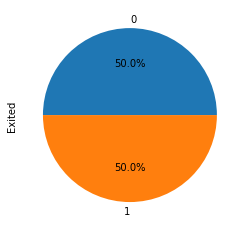

In [25]:
class_frequency = target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='pie', y = "Exited",
                                       label = "Exited",
                                       autopct='%1.1f%%')
plt.show()

Классы сбалансированы.

Обучим модели с учетом дисбаланса и оценим метрику f1.

In [26]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4888507718696398



Для моделей решающее дерево и случайный лес подберем гиперпараметры.

In [27]:
best_model = None
best_result = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result

print("max_depth = ", depth, "F1:", best_result)

max_depth =  10 F1: 0.5862412761714855


In [28]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 101, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("n_estimators = ", est,"max_depth = ", depth, "F1:", best_result)

n_estimators =  100 max_depth =  10 F1: 0.629086809470124


Наилучший результат также показала модель случайный лес с гиперпараметрами n_estimators 100 и max_depth 10. Далее применим технику downsampling, т.е. сделаем объекты частого класса не такими частыми.

In [29]:
features_zeros_downsampled = resample(features_zeros,
             replace=True,
             n_samples=len(features_ones),
             random_state=12345)
features_downsampled = pd.concat([features_zeros_downsampled, features_ones])
target_zeros_downsampled = resample(target_zeros,
             replace=True,
             n_samples=len(target_ones),
             random_state=12345)
target_downsampled = pd.concat([target_zeros_downsampled, target_ones])
print(features_downsampled.shape)
print(target_downsampled.shape)

(2392, 11)
(2392,)


In [31]:
target_downsampled.value_counts()

0    1196
1    1196
Name: Exited, dtype: int64

0    0.5
1    0.5
Name: Exited, dtype: float64


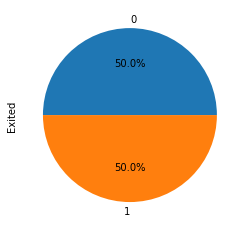

In [32]:
class_frequency = target_downsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='pie', y = "Exited",
                                       label = "Exited",
                                       autopct='%1.1f%%')
plt.show()

Классы сбалансированы.

In [34]:
best_model = None
best_result = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
        best_model = model
        best_result = result

print("max_depth = ", depth, "F1:", best_result)

max_depth =  10 F1: 0.5659690627843494


In [35]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 101, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("n_estimators = ", est,"max_depth = ", depth, "F1:", best_result)

n_estimators =  100 max_depth =  10 F1: 0.6042632066728453


Наилучший результат также показала модель случайный лес с гиперпараметрами n_estimators 100 и max_depth 10. 

## Тестирование модели

Проведем финальное тестирование на тестовой выборке при помощи модели случайный лес, показавшей наилучший результат в ходе эксперементов, при этом сбалансируем веса классов с помощью техники upsampling.

In [36]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.6238938053097346


Построим ROC-кривую случайной модели и обученной нами модели.

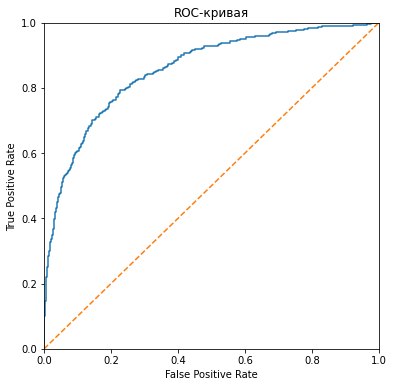

In [37]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0, 1])
plt.xlim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()


Чем выше график ROC-кривой, тем больше значение TPR(доля истинно положительных) и лучше качество модели. Далее посчитаем площадь под ROC-кривой — AUC-ROC, чтобы выявить, как сильно наша модель отличается от случайной.

In [38]:
print(roc_auc_score(target_test, probabilities_one_test))

0.8569972311792896


Полученный результат AUC-ROC нашей модели значительно больше AUC-ROC случайной модели.

Проведенное исследование показало, что подобранная нами модель на основе алгоритма случайный лес показала высокие метрики качества: F1 более 0,59 и AUC-ROC более 0,85. 